# 8 Pilares Estadisticos: Evaluacion de PIB

**Traduciendo conceptos academicos para Data Science al mundo real**

Este notebook evalua el procesamiento de PIB realizado por `ETL_Principales.py`, aplicando los 8 pilares estadisticos fundamentales:

1. **Distribuciones** - Forma de los datos
2. **Centro de Gravedad** - Media, Mediana, Moda
3. **Fiabilidad** - Riesgo y volatilidad
4. **Margen de Error** - Intervalos de confianza
5. **Pruebas de Hipotesis** - Chi-cuadrada
6. **Regresion/Prediccion** - Machine Learning
7. **Series de Tiempo** - Tendencias y estacionalidad
8. **ANOVA** - Comparacion entre grupos

In [1]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import chi2_contingency, shapiro, normaltest, kruskal
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Configuracion de graficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Rutas
BASE_DIR = Path('..').resolve()
DATOS_RESULTADO = BASE_DIR / 'Datos_Resultado'

print(f"Directorio base: {BASE_DIR}")
print(f"Datos resultado: {DATOS_RESULTADO}")

Directorio base: C:\Users\ARTUROJF\Desktop\Final
Datos resultado: C:\Users\ARTUROJF\Desktop\Final\Datos_Resultado


## Carga de Datos

Cargamos los datos procesados por ETL_Principales.py

In [2]:
# ============================================================================
# CARGAR DATOS PROCESADOS
# ============================================================================

path_procesado = DATOS_RESULTADO / 'PIB_procesado.csv'
df = pd.read_csv(path_procesado) if path_procesado.exists() else pd.DataFrame()

print(f"Datos procesados: {len(df)} filas x {len(df.columns)} columnas")
print(f"\nColumnas:")
print(df.columns.tolist())
print(f"\nPrimeras filas:")
df.head(10)

Datos procesados: 102 filas x 5 columnas

Columnas:
['periodo', 'year', 'quarter', 'PIB_nom_trimestral', 'PIB_real_trimestral']

Primeras filas:


,periodo,year,quarter,PIB_nom_trimestral,PIB_real_trimestral
0,2000-01-01,2000,1,6720563.462,1.764971e+07
1,2000-04-01,2000,2,6958394.987,1.786202e+07
2,2000-07-01,2000,3,7166931.104,1.802088e+07
3,2000-10-01,2000,4,7220526.217,1.771481e+07
4,2001-01-01,2001,1,7320286.310,1.776423e+07
5,2001-04-01,2001,2,7459750.438,1.787402e+07
6,2001-07-01,2001,3,7502163.550,1.776106e+07
7,2001-10-01,2001,4,7466230.339,1.752689e+07
8,2002-01-01,2002,1,7309444.307,1.707914e+07
9,2002-04-01,2002,2,7941409.987,1.801680e+07


In [3]:
# Preparar datos para analisis
df['periodo'] = pd.to_datetime(df['periodo'])
df = df.sort_values('periodo').reset_index(drop=True)

# Crear columna TRIMESTRE si no existe
if 'TRIMESTRE' not in df.columns:
    df['TRIMESTRE'] = df['quarter'] if 'quarter' in df.columns else df['periodo'].dt.quarter

# Variables numericas principales
cols_numericas = ['PIB_nom_trimestral', 'PIB_real_trimestral']
cols_numericas = [c for c in cols_numericas if c in df.columns]

print(f"Variables numericas para analisis: {cols_numericas}")

# Variable principal: PIB nominal
VAR_PRINCIPAL = 'PIB_nom_trimestral'
print(f"\nVariable principal: {VAR_PRINCIPAL}")
print(f"Rango: {df[VAR_PRINCIPAL].min():,.0f} - {df[VAR_PRINCIPAL].max():,.0f} millones MXN")
print(f"\nEstadisticas descriptivas:")
df[cols_numericas].describe()

Variables numericas para analisis: ['PIB_nom_trimestral', 'PIB_real_trimestral']

Variable principal: PIB_nom_trimestral
Rango: 6,720,563 - 35,800,605 millones MXN

Estadisticas descriptivas:


,PIB_nom_trimestral,PIB_real_trimestral
count,1.020000e+02,1.020000e+02
mean,1.784893e+07,2.140300e+07
std,8.225427e+06,2.536435e+06
min,6.720563e+06,1.707914e+07
25%,1.123226e+07,1.926264e+07
50%,1.650060e+07,2.147719e+07
75%,2.426646e+07,2.355249e+07
max,3.580061e+07,2.576710e+07


---
## PILAR 1: Distribuciones - ¿Que forma tienen los datos?

**Objetivo:** Identificar si los datos siguen una distribucion normal o requieren transformacion.

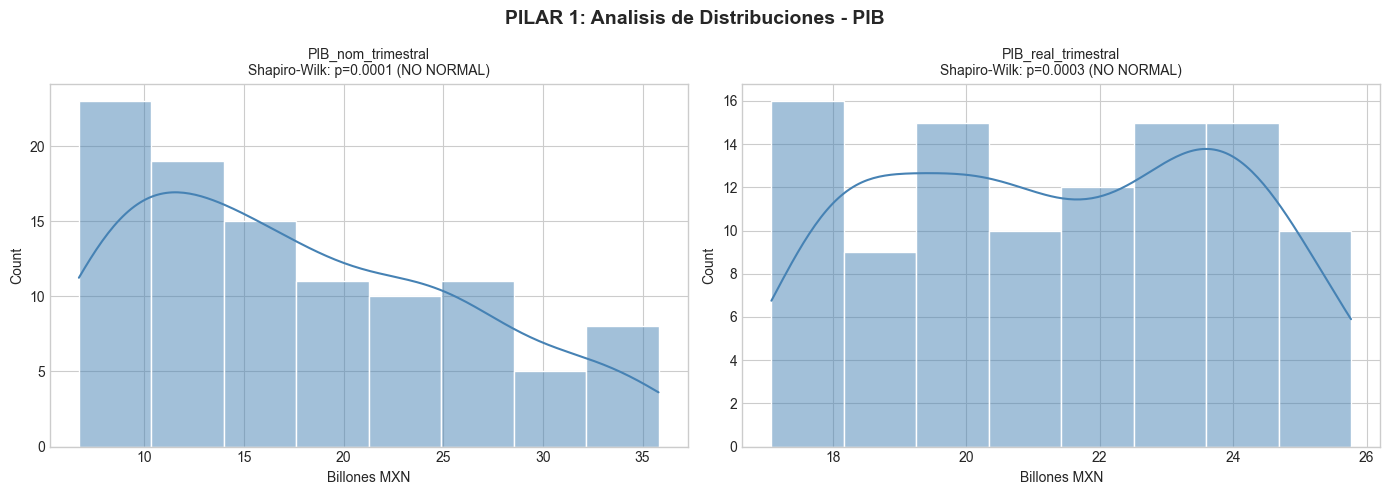


RESUMEN DE NORMALIDAD
PIB_nom_trimestral: p=0.0001 | Sesgo=0.50 | Curtosis=-0.81 | No Normal
PIB_real_trimestral: p=0.0003 | Sesgo=0.00 | Curtosis=-1.28 | No Normal


In [4]:
# ============================================================================
# PILAR 1: DISTRIBUCIONES
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 1: Analisis de Distribuciones - PIB', fontsize=14, fontweight='bold')

for idx, var in enumerate(cols_numericas[:2]):
    ax = axes[idx]
    data = df[var].dropna()
    
    # Histograma con KDE
    sns.histplot(data/1e6, kde=True, ax=ax, color='steelblue', edgecolor='white')
    
    # Test de normalidad
    if len(data) >= 20:
        stat, p_value = shapiro(data) if len(data) < 5000 else normaltest(data)
        test_name = 'Shapiro-Wilk' if len(data) < 5000 else "D'Agostino"
        normalidad = 'NORMAL' if p_value > 0.05 else 'NO NORMAL'
        ax.set_title(f'{var}\n{test_name}: p={p_value:.4f} ({normalidad})', fontsize=10)
    else:
        ax.set_title(f'{var}\n(datos insuficientes)', fontsize=10)
    ax.set_xlabel('Billones MXN')

plt.tight_layout()
plt.show()

# Resumen de normalidad
print("\n" + "="*60)
print("RESUMEN DE NORMALIDAD")
print("="*60)
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 20:
        stat, p = shapiro(data) if len(data) < 5000 else normaltest(data)
        skew = data.skew()
        kurt = data.kurtosis()
        print(f"{var}: p={p:.4f} | Sesgo={skew:.2f} | Curtosis={kurt:.2f} | {'Normal' if p>0.05 else 'No Normal'}")

---
## PILAR 2: Centro de Gravedad - ¿Donde esta el comportamiento tipico?

**Objetivo:** Identificar Media, Mediana y Moda de las variables principales.

PILAR 2: MEDIDAS DE TENDENCIA CENTRAL
           Variable  Media (Billones)  Mediana (Billones)  Diferencia Media-Mediana (%)
 PIB_nom_trimestral         17.848925           16.500595                      8.171400
PIB_real_trimestral         21.403001           21.477191                     -0.345439


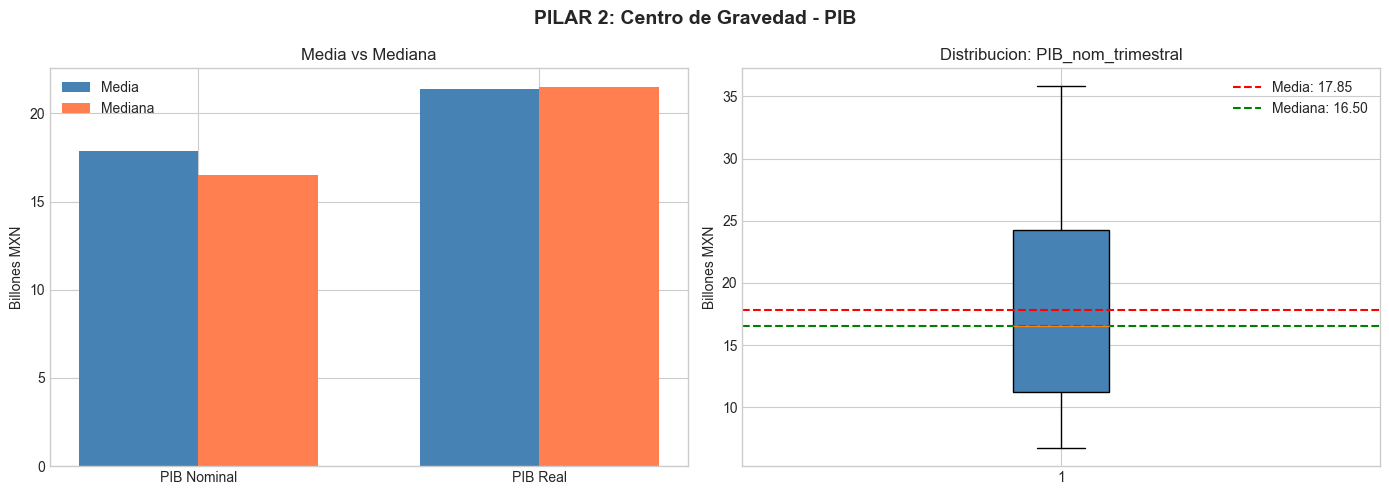

In [5]:
# ============================================================================
# PILAR 2: CENTRO DE GRAVEDAD
# ============================================================================

print("PILAR 2: MEDIDAS DE TENDENCIA CENTRAL")
print("="*80)

# Calcular estadisticas para todas las variables
stats_centro = []
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) > 0:
        stats_centro.append({
            'Variable': var,
            'Media (Billones)': data.mean()/1e6,
            'Mediana (Billones)': data.median()/1e6,
            'Diferencia Media-Mediana (%)': ((data.mean() - data.median()) / data.median() * 100) if data.median() != 0 else 0
        })

df_centro = pd.DataFrame(stats_centro)
print(df_centro.to_string(index=False))

# Visualizacion
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 2: Centro de Gravedad - PIB', fontsize=14, fontweight='bold')

# Grafico 1: Comparacion Media vs Mediana
x = np.arange(len(df_centro))
width = 0.35
axes[0].bar(x - width/2, df_centro['Media (Billones)'], width, label='Media', color='steelblue')
axes[0].bar(x + width/2, df_centro['Mediana (Billones)'], width, label='Mediana', color='coral')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['PIB Nominal', 'PIB Real'], rotation=0)
axes[0].set_ylabel('Billones MXN')
axes[0].set_title('Media vs Mediana')
axes[0].legend()

# Grafico 2: Boxplot de PIB nominal
data_principal = df[VAR_PRINCIPAL].dropna()
bp = axes[1].boxplot(data_principal/1e6, patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
axes[1].axhline(data_principal.mean()/1e6, color='red', linestyle='--', label=f'Media: {data_principal.mean()/1e6:,.2f}')
axes[1].axhline(data_principal.median()/1e6, color='green', linestyle='--', label=f'Mediana: {data_principal.median()/1e6:,.2f}')
axes[1].set_ylabel('Billones MXN')
axes[1].set_title(f'Distribucion: {VAR_PRINCIPAL}')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## PILAR 3: Fiabilidad - ¿Que tan confiables son los datos?

**Objetivo:** Medir riesgo, volatilidad y detectar anomalias.

PILAR 3: MEDIDAS DE DISPERSION Y FIABILIDAD
           Variable  Desv. Std (Billones)    CV (%)  Crec. Prom. Trim (%)  Volatilidad Crec. (%)  Outliers
 PIB_nom_trimestral              8.225427 46.083601              1.737369               3.667138         0
PIB_real_trimestral              2.536435 11.850838              0.439119               3.589608         0


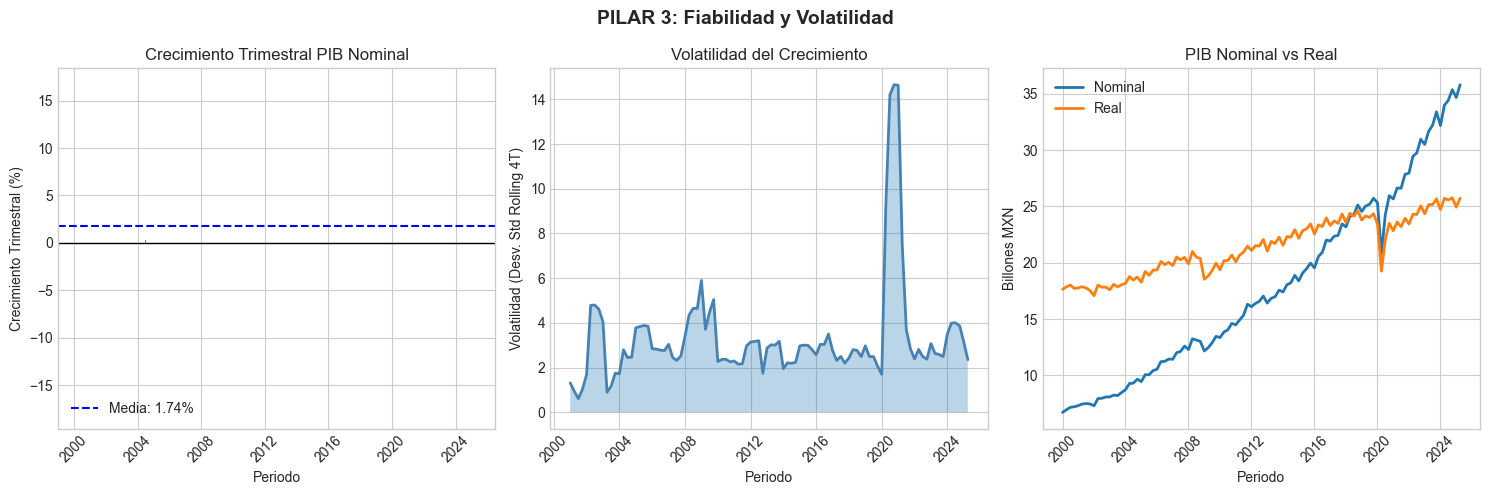

In [6]:
# ============================================================================
# PILAR 3: FIABILIDAD - RIESGO Y VOLATILIDAD
# ============================================================================

print("PILAR 3: MEDIDAS DE DISPERSION Y FIABILIDAD")
print("="*80)

# Calcular metricas de fiabilidad
stats_fiabilidad = []
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) > 0:
        # Coeficiente de variacion (CV)
        cv = (data.std() / data.mean() * 100) if data.mean() != 0 else np.nan
        
        # Deteccion de outliers (IQR)
        Q1, Q3 = data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers = ((data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)).sum()
        
        # Tasa de crecimiento trimestral
        crecimiento = data.pct_change().dropna() * 100
        
        stats_fiabilidad.append({
            'Variable': var,
            'Desv. Std (Billones)': data.std()/1e6,
            'CV (%)': cv,
            'Crec. Prom. Trim (%)': crecimiento.mean(),
            'Volatilidad Crec. (%)': crecimiento.std(),
            'Outliers': outliers
        })

df_fiabilidad = pd.DataFrame(stats_fiabilidad)
print(df_fiabilidad.to_string(index=False))

# Visualizacion
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('PILAR 3: Fiabilidad y Volatilidad', fontsize=14, fontweight='bold')

# Grafico 1: Crecimiento trimestral
crecimiento_nom = df[VAR_PRINCIPAL].pct_change() * 100
axes[0].bar(df['periodo'], crecimiento_nom, 
            color=['green' if x > 0 else 'red' for x in crecimiento_nom], alpha=0.7)
axes[0].axhline(0, color='black', linewidth=1)
axes[0].axhline(crecimiento_nom.mean(), color='blue', linestyle='--', label=f'Media: {crecimiento_nom.mean():.2f}%')
axes[0].set_xlabel('Periodo')
axes[0].set_ylabel('Crecimiento Trimestral (%)')
axes[0].set_title('Crecimiento Trimestral PIB Nominal')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# Grafico 2: Rolling volatilidad
rolling_vol = crecimiento_nom.rolling(window=4).std()
axes[1].plot(df['periodo'], rolling_vol, color='steelblue', linewidth=2)
axes[1].fill_between(df['periodo'], rolling_vol, alpha=0.3)
axes[1].set_xlabel('Periodo')
axes[1].set_ylabel('Volatilidad (Desv. Std Rolling 4T)')
axes[1].set_title('Volatilidad del Crecimiento')
axes[1].tick_params(axis='x', rotation=45)

# Grafico 3: Comparacion PIB Nominal vs Real
if 'PIB_real_trimestral' in df.columns:
    axes[2].plot(df['periodo'], df['PIB_nom_trimestral']/1e6, label='Nominal', linewidth=2)
    axes[2].plot(df['periodo'], df['PIB_real_trimestral']/1e6, label='Real', linewidth=2)
    axes[2].set_xlabel('Periodo')
    axes[2].set_ylabel('Billones MXN')
    axes[2].set_title('PIB Nominal vs Real')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].legend()

plt.tight_layout()
plt.show()

---
## PILAR 4: Margen de Error - Intervalos de Confianza

**Objetivo:** Proporcionar rangos probables con certeza estadistica.

In [7]:
# ============================================================================
# PILAR 4: MARGEN DE ERROR - INTERVALOS DE CONFIANZA
# ============================================================================

print("PILAR 4: INTERVALOS DE CONFIANZA (95%)")
print("="*80)

def intervalo_confianza(data, confianza=0.95):
    """Calcula intervalo de confianza para la media."""
    n = len(data)
    media = data.mean()
    sem = stats.sem(data)
    h = sem * stats.t.ppf((1 + confianza) / 2, n - 1)
    return media - h, media + h, h

# Calcular IC para variables principales
ic_results = []
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 10:
        ic_low, ic_high, margen = intervalo_confianza(data)
        ic_results.append({
            'Variable': var,
            'Media (Billones)': data.mean()/1e6,
            'IC 95% Inf (Billones)': ic_low/1e6,
            'IC 95% Sup (Billones)': ic_high/1e6,
            'Margen de Error (%)': (margen / data.mean() * 100)
        })

df_ic = pd.DataFrame(ic_results)
print(df_ic.to_string(index=False))

# IC para tasa de crecimiento
print("\nIntervalo de Confianza para Tasa de Crecimiento Trimestral:")
crecimiento = df[VAR_PRINCIPAL].pct_change().dropna() * 100
ic_low, ic_high, margen = intervalo_confianza(crecimiento)
print(f"  Media: {crecimiento.mean():.2f}%")
print(f"  IC 95%: [{ic_low:.2f}%, {ic_high:.2f}%]")

PILAR 4: INTERVALOS DE CONFIANZA (95%)
           Variable  Media (Billones)  IC 95% Inf (Billones)  IC 95% Sup (Billones)  Margen de Error (%)
 PIB_nom_trimestral         17.848925              16.233298              19.464552             9.051678
PIB_real_trimestral         21.403001              20.904798              21.901204             2.327725

Intervalo de Confianza para Tasa de Crecimiento Trimestral:
  Media: 1.74%
  IC 95%: [1.01%, 2.46%]


---
## PILAR 5: Pruebas de Hipotesis - ¿Fue suerte o fue real?

**Objetivo:** Validar afirmaciones con evidencia estadistica usando Chi-Cuadrada.

In [8]:
# ============================================================================
# PILAR 5: PRUEBAS DE HIPOTESIS - CHI-CUADRADA
# ============================================================================

print("PILAR 5: PRUEBAS DE HIPOTESIS")
print("="*80)

# Hipotesis 1: ¿El crecimiento del PIB es independiente del trimestre?
print("\n--- HIPOTESIS 1: Independencia Crecimiento PIB vs Trimestre ---")
print("H0: El crecimiento del PIB (positivo/negativo) es independiente del trimestre")
print("H1: El crecimiento depende del trimestre")

# Crear variable categorica: crecimiento positivo o negativo
df_test = df.copy()
df_test['crecimiento'] = df_test[VAR_PRINCIPAL].pct_change()
df_test['crec_signo'] = df_test['crecimiento'].apply(lambda x: 'Positivo' if x > 0 else 'Negativo' if x < 0 else 'Neutro')
df_test = df_test.dropna(subset=['crec_signo'])

# Tabla de contingencia
contingencia = pd.crosstab(df_test['crec_signo'], df_test['TRIMESTRE'])
print("\nTabla de Contingencia:")
print(contingencia)

# Test Chi-cuadrada
if contingencia.shape[0] > 1 and contingencia.shape[1] > 1:
    chi2, p_value, dof, expected = chi2_contingency(contingencia)
    print(f"\nEstadistico Chi-cuadrada: {chi2:.4f}")
    print(f"Grados de libertad: {dof}")
    print(f"p-value: {p_value:.4f}")
    print(f"\nConclusion: {'RECHAZAR H0' if p_value < 0.05 else 'NO RECHAZAR H0'} (alfa=0.05)")
else:
    print("Datos insuficientes para el test")
    chi2, p_value = 0, 1.0

PILAR 5: PRUEBAS DE HIPOTESIS

--- HIPOTESIS 1: Independencia Crecimiento PIB vs Trimestre ---
H0: El crecimiento del PIB (positivo/negativo) es independiente del trimestre
H1: El crecimiento depende del trimestre

Tabla de Contingencia:
TRIMESTRE    1   2   3   4
crec_signo                
Negativo    20   1   3   2
Neutro       1   0   0   0
Positivo     5  25  22  23

Estadistico Chi-cuadrada: 53.5762
Grados de libertad: 6
p-value: 0.0000

Conclusion: RECHAZAR H0 (alfa=0.05)


In [9]:
# Hipotesis 2: ¿El PIB cambio significativamente antes/despues de 2010?
print("\n--- HIPOTESIS 2: Cambio estructural 2010 ---")
print("H0: El nivel de PIB es independiente del periodo (pre/post 2010)")
print("H1: El PIB depende del periodo")

df_test['era'] = df_test['periodo'].apply(lambda x: 'Pre-2010' if x.year < 2010 else 'Post-2010')
df_test['pib_cat'] = pd.qcut(df_test[VAR_PRINCIPAL], q=3, labels=['Bajo', 'Medio', 'Alto'])

# Tabla de contingencia
contingencia2 = pd.crosstab(df_test['pib_cat'], df_test['era'])
print("\nTabla de Contingencia (Nivel PIB vs Era):")
print(contingencia2)

if contingencia2.shape[0] > 1 and contingencia2.shape[1] > 1:
    chi2_2, p_value_2, dof_2, expected_2 = chi2_contingency(contingencia2)
    print(f"\nEstadistico Chi-cuadrada: {chi2_2:.4f}")
    print(f"p-value: {p_value_2:.6f}")
    print(f"\nConclusion: {'RECHAZAR H0' if p_value_2 < 0.05 else 'NO RECHAZAR H0'} (alfa=0.05)")
else:
    print("Datos insuficientes para el test")
    p_value_2 = 1.0


--- HIPOTESIS 2: Cambio estructural 2010 ---
H0: El nivel de PIB es independiente del periodo (pre/post 2010)
H1: El PIB depende del periodo

Tabla de Contingencia (Nivel PIB vs Era):
era      Post-2010  Pre-2010
pib_cat                     
Bajo             0        34
Medio           28         6
Alto            34         0

Estadistico Chi-cuadrada: 81.2710
p-value: 0.000000

Conclusion: RECHAZAR H0 (alfa=0.05)


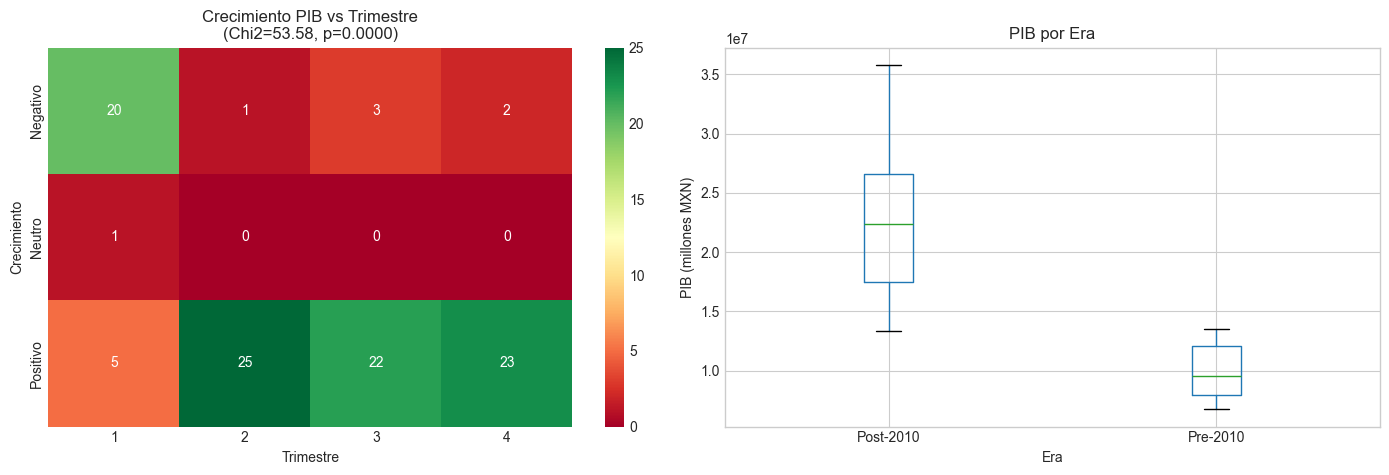

In [10]:
# Visualizacion de pruebas de hipotesis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 5: Pruebas de Hipotesis - Chi-Cuadrada', fontsize=14, fontweight='bold')

# Grafico 1: Heatmap de contingencia
sns.heatmap(contingencia, annot=True, fmt='d', cmap='RdYlGn', ax=axes[0])
axes[0].set_title(f'Crecimiento PIB vs Trimestre\n(Chi2={chi2:.2f}, p={p_value:.4f})')
axes[0].set_xlabel('Trimestre')
axes[0].set_ylabel('Crecimiento')

# Grafico 2: PIB por era
df_test.boxplot(column=VAR_PRINCIPAL, by='era', ax=axes[1])
axes[1].set_title('PIB por Era')
axes[1].set_xlabel('Era')
axes[1].set_ylabel('PIB (millones MXN)')
plt.suptitle('')

plt.tight_layout()
plt.show()

---
## PILAR 6: Regresion/Prediccion - ¿Como predecir el futuro?

**Objetivo:** Modelar relaciones para anticipar resultados usando Machine Learning.

In [11]:
# ============================================================================
# PILAR 6: PREDICCION CON MACHINE LEARNING
# ============================================================================

print("PILAR 6: MODELOS DE PREDICCION - MACHINE LEARNING")
print("="*80)

# Crear features temporales
df_ml = df.copy()
df_ml['year'] = df_ml['periodo'].dt.year
df_ml['month'] = df_ml['periodo'].dt.month
df_ml['time_index'] = range(len(df_ml))

# Lag features
df_ml['pib_lag1'] = df_ml[VAR_PRINCIPAL].shift(1)
df_ml['pib_lag4'] = df_ml[VAR_PRINCIPAL].shift(4)  # Mismo trimestre ano anterior

# Features y target
features = ['TRIMESTRE', 'year', 'time_index', 'pib_lag1', 'pib_lag4']
target = VAR_PRINCIPAL

print(f"Features para modelo: {features}")
print(f"Target: {target}")

# Preparar dataset
df_ml = df_ml[features + [target]].dropna()
X = df_ml[features]
y = df_ml[target]

print(f"\nDatos para entrenamiento: {len(df_ml)} observaciones")

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

PILAR 6: MODELOS DE PREDICCION - MACHINE LEARNING
Features para modelo: ['TRIMESTRE', 'year', 'time_index', 'pib_lag1', 'pib_lag4']
Target: PIB_nom_trimestral

Datos para entrenamiento: 98 observaciones


In [12]:
# Entrenar multiples modelos
modelos = {
    'Regresion Lineal': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

resultados = []
predicciones = {}

for nombre, modelo in modelos.items():
    # Entrenar
    if 'Forest' in nombre or 'Boosting' in nombre:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
    else:
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
    
    # Metricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    resultados.append({
        'Modelo': nombre,
        'RMSE (Millones)': rmse,
        'MAE (Millones)': mae,
        'R2': r2,
        'MAPE (%)': (mae / y_test.mean() * 100)
    })
    predicciones[nombre] = y_pred

df_resultados = pd.DataFrame(resultados).sort_values('R2', ascending=False)
print("\nCOMPARACION DE MODELOS:")
print(df_resultados.to_string(index=False))

# Mejor modelo
mejor_modelo = df_resultados.iloc[0]['Modelo']
print(f"\n*** MEJOR MODELO: {mejor_modelo} (R2 = {df_resultados.iloc[0]['R2']:.4f}) ***")


COMPARACION DE MODELOS:
           Modelo  RMSE (Millones)  MAE (Millones)       R2  MAPE (%)
            Ridge    566178.382053   372247.377233 0.995342  2.093022
 Regresion Lineal    582297.784261   348214.911599 0.995073  1.957896
Gradient Boosting    628872.751737   388124.997147 0.994253  2.182297
    Random Forest    656373.511178   421169.951243 0.993740  2.368098

*** MEJOR MODELO: Ridge (R2 = 0.9953) ***


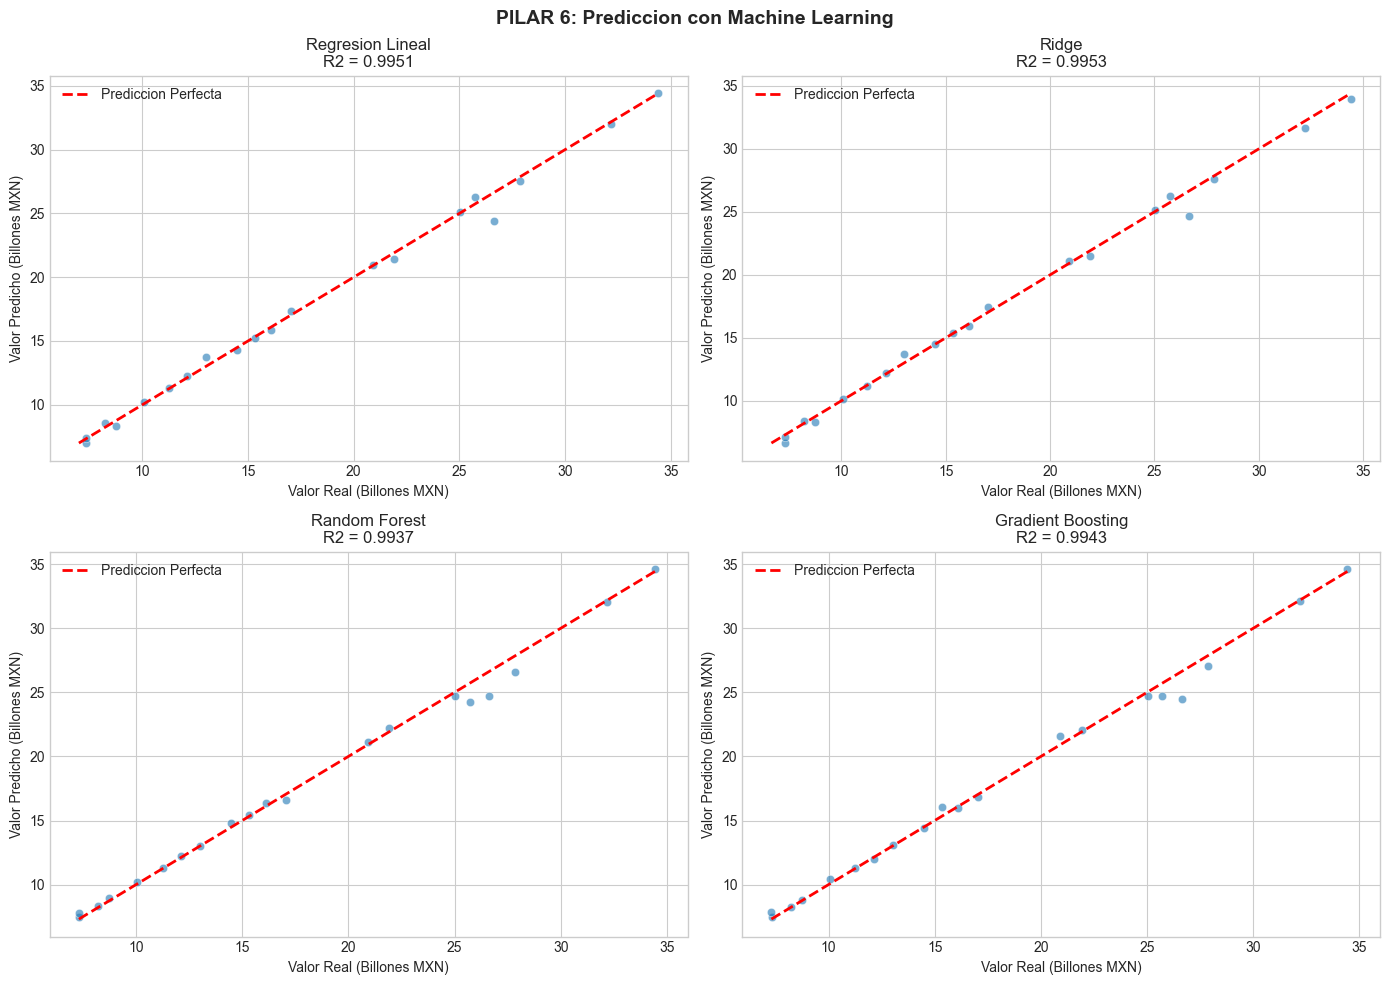

In [13]:
# Visualizacion de predicciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PILAR 6: Prediccion con Machine Learning', fontsize=14, fontweight='bold')

for idx, (nombre, y_pred) in enumerate(predicciones.items()):
    ax = axes[idx // 2, idx % 2]
    ax.scatter(y_test/1e6, y_pred/1e6, alpha=0.6, edgecolors='white', linewidth=0.5)
    
    # Linea de referencia perfecta
    min_val, max_val = min(y_test.min(), y_pred.min())/1e6, max(y_test.max(), y_pred.max())/1e6
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prediccion Perfecta')
    
    r2 = r2_score(y_test, y_pred)
    ax.set_xlabel('Valor Real (Billones MXN)')
    ax.set_ylabel('Valor Predicho (Billones MXN)')
    ax.set_title(f'{nombre}\nR2 = {r2:.4f}')
    ax.legend()

plt.tight_layout()
plt.show()


IMPORTANCIA DE VARIABLES (Random Forest):
   Feature  Importancia
  pib_lag4     0.314523
time_index     0.305477
  pib_lag1     0.287126
      year     0.092183
 TRIMESTRE     0.000692


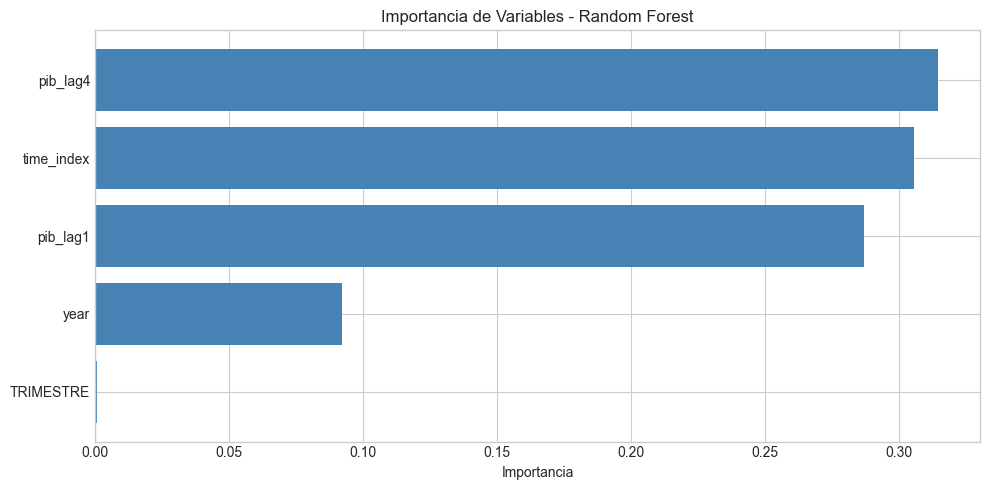

In [14]:
# Importancia de features (Random Forest)
rf_model = modelos['Random Forest']
importancia = pd.DataFrame({
    'Feature': features,
    'Importancia': rf_model.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\nIMPORTANCIA DE VARIABLES (Random Forest):")
print(importancia.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(importancia['Feature'], importancia['Importancia'], color='steelblue')
ax.set_xlabel('Importancia')
ax.set_title('Importancia de Variables - Random Forest')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

---
## PILAR 7: Series de Tiempo - ¿Que patrones se repiten?

**Objetivo:** Detectar tendencias y estacionalidad para pronosticos precisos.

In [15]:
# ============================================================================
# PILAR 7: SERIES DE TIEMPO
# ============================================================================

print("PILAR 7: ANALISIS DE SERIES DE TIEMPO")
print("="*80)

# Preparar serie temporal
ts_data = df.set_index('periodo')[VAR_PRINCIPAL].dropna()
ts_data = ts_data.asfreq('QS')

print(f"Serie temporal: {VAR_PRINCIPAL}")
print(f"Periodo: {ts_data.index.min()} a {ts_data.index.max()}")
print(f"Observaciones: {len(ts_data)}")

# Test de estacionariedad (Dickey-Fuller)
adf_result = adfuller(ts_data.dropna())
print(f"\nTest Dickey-Fuller Aumentado:")
print(f"  Estadistico ADF: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.4f}")
print(f"\n  Conclusion: {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'} (alfa=0.05)")

# Test en diferencias (crecimiento)
ts_diff = ts_data.pct_change().dropna()
adf_diff = adfuller(ts_diff)
print(f"\nTest ADF en diferencias (crecimiento):")
print(f"  p-value: {adf_diff[1]:.4f} - {'ESTACIONARIA' if adf_diff[1] < 0.05 else 'NO ESTACIONARIA'}")

PILAR 7: ANALISIS DE SERIES DE TIEMPO
Serie temporal: PIB_nom_trimestral
Periodo: 2000-01-01 00:00:00 a 2025-04-01 00:00:00
Observaciones: 102

Test Dickey-Fuller Aumentado:
  Estadistico ADF: 2.9736
  p-value: 1.0000

  Conclusion: NO ESTACIONARIA (alfa=0.05)

Test ADF en diferencias (crecimiento):
  p-value: 0.0000 - ESTACIONARIA


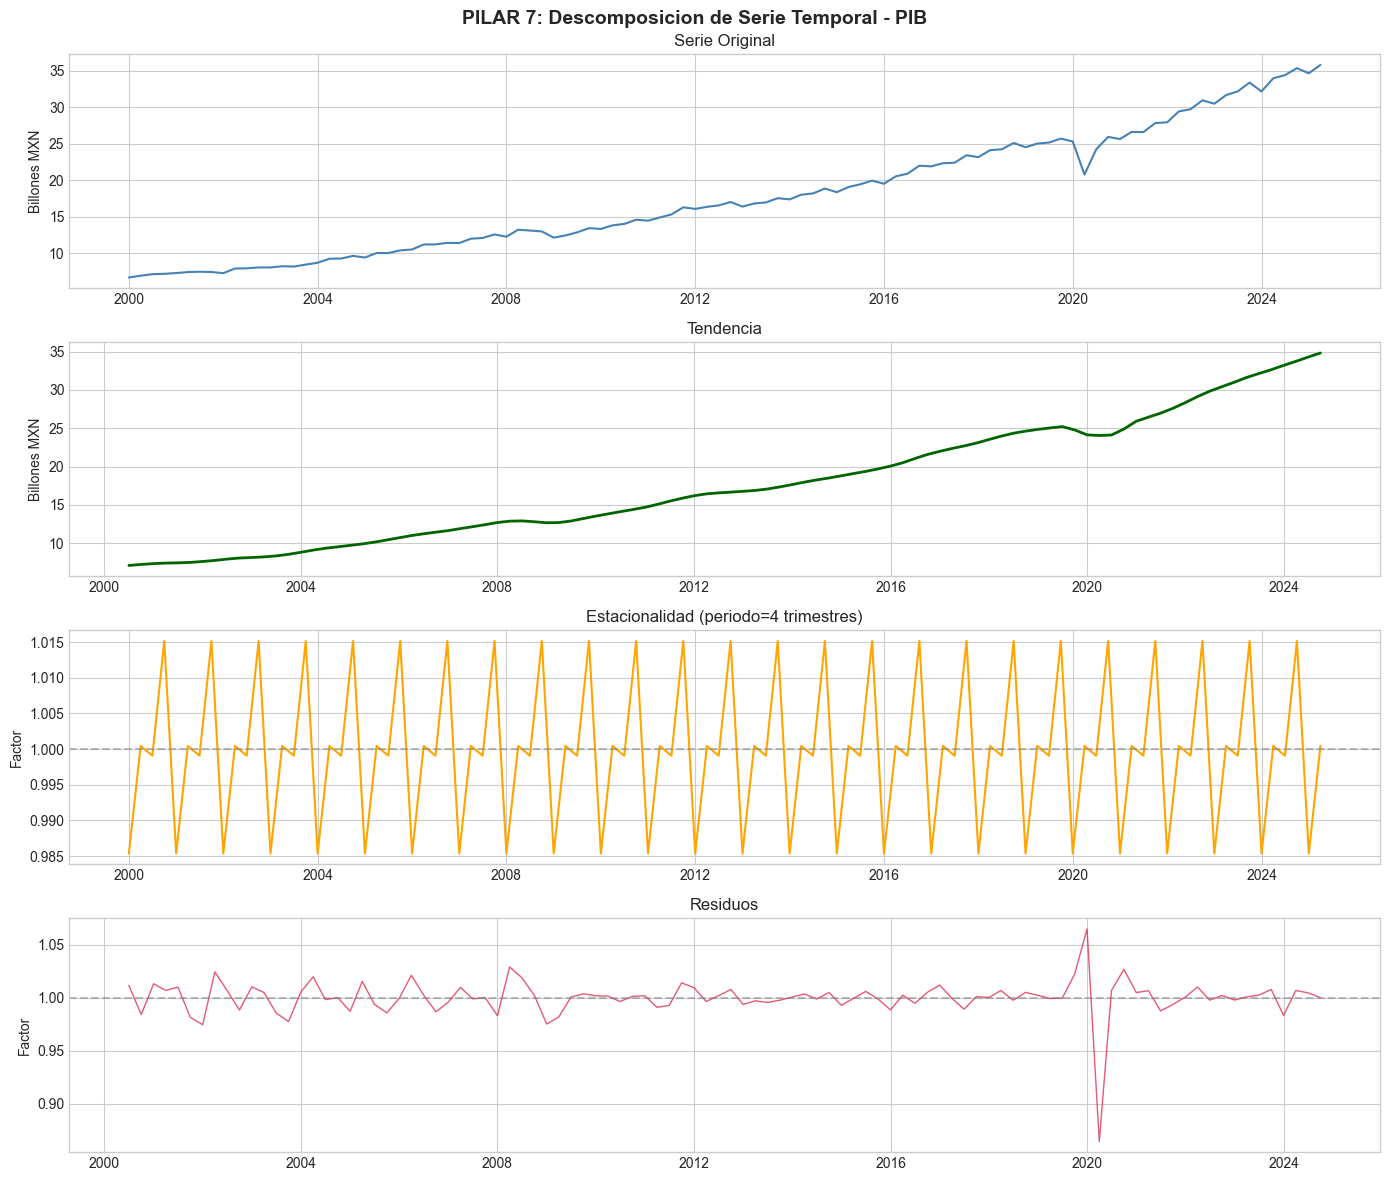


ESTADISTICAS DE COMPONENTES:
  Tendencia - Crecimiento total: 391.2%
  Estacionalidad - Rango: 0.985 - 1.015


In [16]:
# Descomposicion de la serie
if len(ts_data.dropna()) >= 8:
    decomposition = seasonal_decompose(ts_data.dropna(), model='multiplicative', period=4)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    fig.suptitle('PILAR 7: Descomposicion de Serie Temporal - PIB', fontsize=14, fontweight='bold')
    
    axes[0].plot(ts_data/1e6, color='steelblue', linewidth=1.5)
    axes[0].set_title('Serie Original')
    axes[0].set_ylabel('Billones MXN')
    
    axes[1].plot(decomposition.trend/1e6, color='darkgreen', linewidth=2)
    axes[1].set_title('Tendencia')
    axes[1].set_ylabel('Billones MXN')
    
    axes[2].plot(decomposition.seasonal, color='orange', linewidth=1.5)
    axes[2].set_title('Estacionalidad (periodo=4 trimestres)')
    axes[2].set_ylabel('Factor')
    axes[2].axhline(1, color='gray', linestyle='--', alpha=0.5)
    
    axes[3].plot(decomposition.resid, color='crimson', linewidth=1, alpha=0.7)
    axes[3].set_title('Residuos')
    axes[3].set_ylabel('Factor')
    axes[3].axhline(1, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print("\nESTADISTICAS DE COMPONENTES:")
    print(f"  Tendencia - Crecimiento total: {((decomposition.trend.dropna().iloc[-1]/decomposition.trend.dropna().iloc[0])-1)*100:.1f}%")
    print(f"  Estacionalidad - Rango: {decomposition.seasonal.min():.3f} - {decomposition.seasonal.max():.3f}")

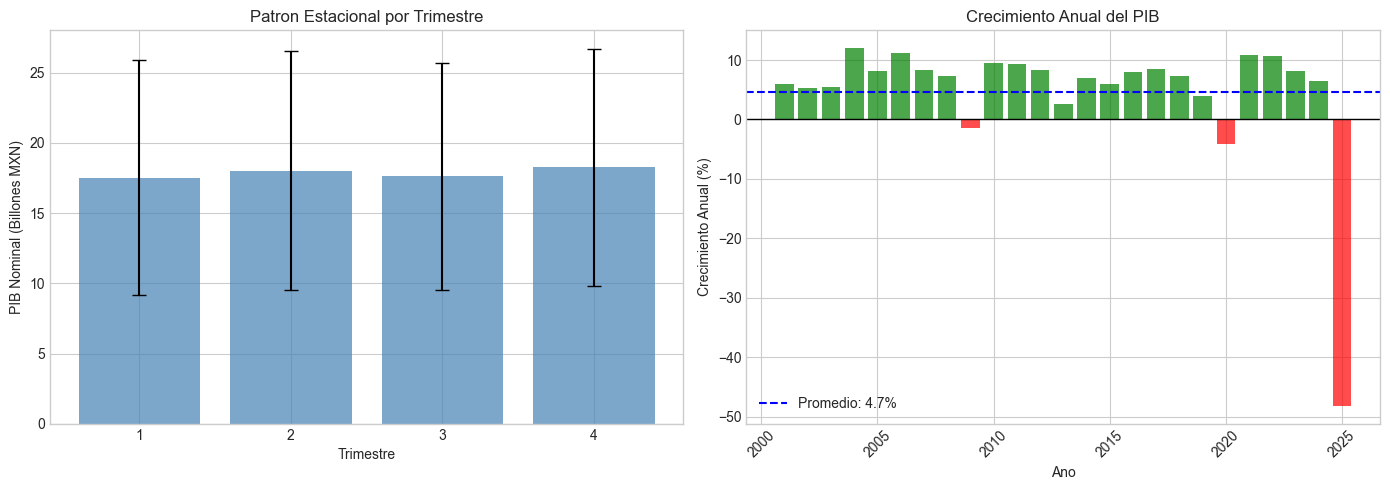

In [17]:
# Patron estacional por trimestre
patron_trimestral = df.groupby('TRIMESTRE')[VAR_PRINCIPAL].agg(['mean', 'std'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Patron por trimestre
axes[0].bar(patron_trimestral.index, patron_trimestral['mean']/1e6, 
            yerr=patron_trimestral['std']/1e6, capsize=5, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Trimestre')
axes[0].set_ylabel('PIB Nominal (Billones MXN)')
axes[0].set_title('Patron Estacional por Trimestre')
axes[0].set_xticks([1, 2, 3, 4])

# Tasa de crecimiento anual (YoY)
df['year'] = df['periodo'].dt.year
crecimiento_anual = df.groupby('year')[VAR_PRINCIPAL].sum().pct_change() * 100
colors = ['green' if x > 0 else 'red' for x in crecimiento_anual]
axes[1].bar(crecimiento_anual.index, crecimiento_anual.values, color=colors, alpha=0.7)
axes[1].axhline(0, color='black', linewidth=1)
axes[1].axhline(crecimiento_anual.mean(), color='blue', linestyle='--', 
                label=f'Promedio: {crecimiento_anual.mean():.1f}%')
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Crecimiento Anual (%)')
axes[1].set_title('Crecimiento Anual del PIB')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()

---
## PILAR 8: ANOVA - ¿Que estrategia es mejor?

**Objetivo:** Comparar rendimiento entre grupos objetivamente.

In [18]:
# ============================================================================
# PILAR 8: ANOVA - COMPARACION ENTRE GRUPOS
# ============================================================================

print("PILAR 8: ANALISIS DE VARIANZA (ANOVA)")
print("="*80)

# Analisis 1: Comparar crecimiento entre trimestres
print("\n--- ANOVA 1: Crecimiento PIB por Trimestre ---")
print("H0: El crecimiento del PIB es igual en todos los trimestres")
print("H1: Al menos un trimestre tiene crecimiento diferente")

df['crecimiento_pct'] = df[VAR_PRINCIPAL].pct_change() * 100
grupos_trim = [df[df['TRIMESTRE'] == t]['crecimiento_pct'].dropna() for t in [1, 2, 3, 4]]
grupos_trim = [g for g in grupos_trim if len(g) >= 3]

if len(grupos_trim) >= 2:
    f_stat, p_anova = stats.f_oneway(*grupos_trim)
    print(f"\nEstadistico F: {f_stat:.4f}")
    print(f"p-value: {p_anova:.4f}")
    print(f"Conclusion: {'RECHAZAR H0' if p_anova < 0.05 else 'NO RECHAZAR H0'} (alfa=0.05)")
    
    h_stat, p_kruskal = kruskal(*grupos_trim)
    print(f"\nKruskal-Wallis: H={h_stat:.4f}, p={p_kruskal:.4f}")
else:
    f_stat, p_anova = 0, 1.0
    print("Datos insuficientes")

PILAR 8: ANALISIS DE VARIANZA (ANOVA)

--- ANOVA 1: Crecimiento PIB por Trimestre ---
H0: El crecimiento del PIB es igual en todos los trimestres
H1: Al menos un trimestre tiene crecimiento diferente

Estadistico F: 11.9673
p-value: 0.0000
Conclusion: RECHAZAR H0 (alfa=0.05)

Kruskal-Wallis: H=58.2758, p=0.0000


In [19]:
# Analisis 2: Comparar PIB entre decadas
print("\n--- ANOVA 2: PIB por Decada ---")

df['decada'] = (df['periodo'].dt.year // 10) * 10
decadas = df['decada'].unique()
grupos_decada = [df[df['decada'] == d][VAR_PRINCIPAL].dropna() for d in sorted(decadas)]
grupos_decada = [g for g in grupos_decada if len(g) >= 3]

if len(grupos_decada) >= 2:
    f_stat2, p_anova2 = stats.f_oneway(*grupos_decada)
    print(f"\nEstadistico F: {f_stat2:.4f}")
    print(f"p-value: {p_anova2:.6f}")
    print(f"Conclusion: {'RECHAZAR H0' if p_anova2 < 0.05 else 'NO RECHAZAR H0'}")
else:
    f_stat2, p_anova2 = 0, 1.0
    print("Datos insuficientes")


--- ANOVA 2: PIB por Decada ---

Estadistico F: 267.8093
p-value: 0.000000
Conclusion: RECHAZAR H0


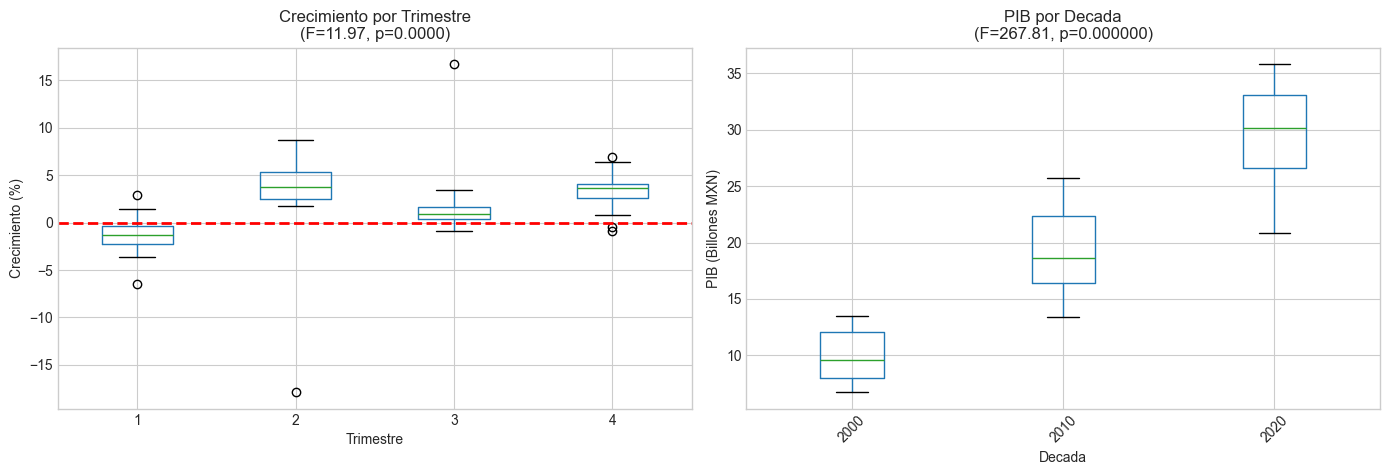

In [20]:
# Visualizacion ANOVA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 8: ANOVA - Comparacion entre Grupos', fontsize=14, fontweight='bold')

# Grafico 1: Boxplot crecimiento por trimestre
df.boxplot(column='crecimiento_pct', by='TRIMESTRE', ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_title(f'Crecimiento por Trimestre\n(F={f_stat:.2f}, p={p_anova:.4f})')
axes[0].set_xlabel('Trimestre')
axes[0].set_ylabel('Crecimiento (%)')
plt.suptitle('')

# Grafico 2: Boxplot PIB por decada
df_plot = df.copy()
df_plot[VAR_PRINCIPAL] = df_plot[VAR_PRINCIPAL] / 1e6
df_plot.boxplot(column=VAR_PRINCIPAL, by='decada', ax=axes[1])
axes[1].set_title(f'PIB por Decada\n(F={f_stat2:.2f}, p={p_anova2:.6f})')
axes[1].set_xlabel('Decada')
axes[1].set_ylabel('PIB (Billones MXN)')
axes[1].tick_params(axis='x', rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.show()

In [21]:
# Estadisticas descriptivas
print("\nESTADISTICAS DE CRECIMIENTO POR TRIMESTRE:")
print(df.groupby('TRIMESTRE')['crecimiento_pct'].agg(['count', 'mean', 'std', 'min', 'max']).round(2))

print("\nESTADISTICAS DE PIB POR DECADA (Billones MXN):")
stats_decada = df.groupby('decada')[VAR_PRINCIPAL].agg(['count', 'mean', 'std', 'min', 'max'])
stats_decada[['mean', 'std', 'min', 'max']] = stats_decada[['mean', 'std', 'min', 'max']] / 1e6
print(stats_decada.round(2))


ESTADISTICAS DE CRECIMIENTO POR TRIMESTRE:
           count  mean   std    min    max
TRIMESTRE                                 
1             25 -1.34  1.87  -6.52   2.95
2             26  3.32  4.71 -17.89   8.65
3             25  1.61  3.31  -0.86  16.68
4             25  3.30  1.83  -0.92   6.94

ESTADISTICAS DE PIB POR DECADA (Billones MXN):
        count   mean   std    min    max
decada                                  
2000       40   9.86  2.18   6.72  13.47
2010       40  19.27  3.69  13.36  25.72
2020       22  29.79  4.08  20.80  35.80


---
## RESUMEN EJECUTIVO

Sintesis de los hallazgos de los 8 pilares estadisticos.

In [22]:
# ============================================================================
# RESUMEN EJECUTIVO
# ============================================================================

print("="*80)
print("RESUMEN EJECUTIVO: 8 PILARES ESTADISTICOS - PIB")
print("="*80)

print("\n1. DISTRIBUCIONES:")
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 20:
        _, p = shapiro(data) if len(data) < 5000 else normaltest(data)
        print(f"   - {var}: {'Normal' if p > 0.05 else 'No Normal'} (p={p:.4f})")

print("\n2. CENTRO DE GRAVEDAD:")
print(f"   - PIB Nominal Promedio: {df[VAR_PRINCIPAL].mean()/1e6:,.2f} billones MXN")
print(f"   - Mediana: {df[VAR_PRINCIPAL].median()/1e6:,.2f} billones MXN")

print("\n3. FIABILIDAD:")
cv_principal = df[VAR_PRINCIPAL].std() / df[VAR_PRINCIPAL].mean() * 100
crec = df[VAR_PRINCIPAL].pct_change().dropna() * 100
print(f"   - Coeficiente de Variacion: {cv_principal:.1f}%")
print(f"   - Crecimiento Promedio Trimestral: {crec.mean():.2f}%")
print(f"   - Volatilidad del Crecimiento: {crec.std():.2f}%")

print("\n4. MARGEN DE ERROR:")
ic_low, ic_high, margen = intervalo_confianza(df[VAR_PRINCIPAL].dropna())
print(f"   - IC 95%: [{ic_low/1e6:,.2f}, {ic_high/1e6:,.2f}] billones MXN")

print("\n5. PRUEBAS DE HIPOTESIS (Chi-Cuadrada):")
print(f"   - Crecimiento vs Trimestre: {'Dependientes' if p_value < 0.05 else 'Independientes'} (p={p_value:.4f})")

print("\n6. PREDICCION (Machine Learning):")
print(f"   - Mejor modelo: {mejor_modelo}")
print(f"   - R2 = {df_resultados.iloc[0]['R2']:.4f}")

print("\n7. SERIES DE TIEMPO:")
print(f"   - Serie en niveles: {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'}")
print(f"   - Serie en diferencias: {'ESTACIONARIA' if adf_diff[1] < 0.05 else 'NO ESTACIONARIA'}")

print("\n8. ANOVA:")
print(f"   - Diferencia en crecimiento entre trimestres: {'SI' if p_anova < 0.05 else 'NO'} (p={p_anova:.4f})")
print(f"   - Diferencia en PIB entre decadas: {'SI' if p_anova2 < 0.05 else 'NO'} (p={p_anova2:.6f})")

print("\n" + "="*80)
print("FIN DEL ANALISIS")
print("="*80)

RESUMEN EJECUTIVO: 8 PILARES ESTADISTICOS - PIB

1. DISTRIBUCIONES:
   - PIB_nom_trimestral: No Normal (p=0.0001)
   - PIB_real_trimestral: No Normal (p=0.0003)

2. CENTRO DE GRAVEDAD:
   - PIB Nominal Promedio: 17.85 billones MXN
   - Mediana: 16.50 billones MXN

3. FIABILIDAD:
   - Coeficiente de Variacion: 46.1%
   - Crecimiento Promedio Trimestral: 1.74%
   - Volatilidad del Crecimiento: 3.67%

4. MARGEN DE ERROR:
   - IC 95%: [16.23, 19.46] billones MXN

5. PRUEBAS DE HIPOTESIS (Chi-Cuadrada):
   - Crecimiento vs Trimestre: Dependientes (p=0.0000)

6. PREDICCION (Machine Learning):
   - Mejor modelo: Ridge
   - R2 = 0.9953

7. SERIES DE TIEMPO:
   - Serie en niveles: NO ESTACIONARIA
   - Serie en diferencias: ESTACIONARIA

8. ANOVA:
   - Diferencia en crecimiento entre trimestres: SI (p=0.0000)
   - Diferencia en PIB entre decadas: SI (p=0.000000)

FIN DEL ANALISIS
